# LoRA Fine-Tuning with APO-up Loss

Fine-tuning Mistral-7B-Instruct-v0.2 using:
- **LoRA** (rank-8) on `q_proj, v_proj`
- **APO-up loss** (Anchored Preference Optimization)
- **8-bit quantization** for memory efficiency (~24GB GPU)

Dataset: `short_ft.jsonl` with "prompt", "chosen", "rejected" fields.


## 1. Install Dependencies


In [3]:
# === CONFIGURATION ===
LORA_RANK = 8  # Change this to adjust LoRA rank for fine-tuning

!pip install -q transformers accelerate bitsandbytes torch peft


## 2. Upload Dataset


In [4]:
from google.colab import files
import json

# Upload short_ft.jsonl
print("Please upload short_ft.jsonl")
uploaded = files.upload()

# Load dataset
examples = []
with open("short_ft.jsonl", "r") as f:
    for line in f:
        if line.strip():
            examples.append(json.loads(line))

print(f"Loaded {len(examples)} examples.")
print(f"First example:")
print(f"  Prompt: {examples[0]['prompt'][:100]}...")
print(f"  Chosen: {examples[0]['chosen'][:100]}...")
print(f"  Rejected: {examples[0]['rejected'][:100]}...")


Please upload short_ft.jsonl


Saving short_ft.jsonl to short_ft.jsonl
Loaded 1030 examples.
First example:
  Prompt: Can brain cells move? By movement I mean long distance migration (preferably within the brain only)....
  Chosen: Yes, certain brain cells, like neural stem cells and some types of glial cells, can migrate long dis...
  Rejected: The question of whether brain cells can move, particularly in terms of long-distance migration withi...


## 3. Load Model with 8-bit Quantization + LoRA


In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

# 8-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

# Load model in 8-bit
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

# Prepare model for k-bit training (required for QLoRA)
model = prepare_model_for_kbit_training(model)

# LoRA config: on q_proj, v_proj (minimal, comparable to targeted training)
lora_config = LoraConfig(
    r=LORA_RANK,  # rank (set at top of notebook)
    lora_alpha=LORA_RANK * 2,  # scaling factor (typically 2x rank)
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

# Apply LoRA
model = get_peft_model(model, lora_config)

print(f"Model loaded with LoRA adapters.")
model.print_trainable_parameters()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded with LoRA adapters.
trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


## 4. APO-up Loss Functions


In [6]:
import torch.nn.functional as F

BETA = 0.2

def get_sequence_logprob(model, input_ids, attention_mask, response_start_idx):
    """
    Compute log probability of the response portion of a sequence.
    response_start_idx: index where the response tokens begin
    """
    with torch.amp.autocast('cuda', dtype=torch.bfloat16):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch, seq_len, vocab]

    # Shift for next-token prediction
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute log probs
    log_probs = F.log_softmax(shift_logits, dim=-1)
    token_log_probs = torch.gather(log_probs, dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    # Mask: only count response tokens (after response_start_idx)
    response_mask = torch.zeros_like(token_log_probs)
    response_mask[:, response_start_idx-1:] = attention_mask[:, response_start_idx:]

    # Sum log probs over response
    seq_log_prob = (token_log_probs * response_mask).sum(dim=-1)
    return seq_log_prob


def compute_ref_logprob(model, input_ids, attention_mask, response_start_idx):
    """
    Compute logprob using reference model (LoRA adapters disabled).
    """
    # Disable LoRA adapters to get reference (base model) behavior
    model.disable_adapter_layers()

    with torch.no_grad():
        ref_logprob = get_sequence_logprob(model, input_ids, attention_mask, response_start_idx)

    # Re-enable LoRA adapters
    model.enable_adapter_layers()

    return ref_logprob


def dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected, beta=BETA):
    """
    DPO + APO-up loss:
    t1 = -log(sigmoid(beta * (logp_c - logp_r - (ref_logp_c - ref_logp_r))))  [DPO term]
    t2 = -log(sigmoid(beta * (logp_c - ref_logp_c)))  [APO-up term: anchor chosen likelihood]
    """
    # DPO term
    logit_diff = logp_chosen - logp_rejected - (ref_logp_chosen - ref_logp_rejected)
    t1 = -F.logsigmoid(beta * logit_diff)

    # APO-up term (anchoring chosen likelihood)
    t2 = -F.logsigmoid(beta * (logp_chosen - ref_logp_chosen))

    return t1 + t2

print("APO-up loss functions defined.")


APO-up loss functions defined.


## 5. Data Preparation


In [7]:
def prepare_example(tokenizer, prompt, response, max_length=1024):
    """
    Tokenize prompt + response, return input_ids, attention_mask, and response start index.
    """
    # Tokenize prompt separately to find where response starts
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=True)
    response_ids = tokenizer.encode(response, add_special_tokens=False)

    # Combine
    full_ids = prompt_ids + response_ids

    # Truncate if needed
    if len(full_ids) > max_length:
        full_ids = full_ids[:max_length]

    response_start_idx = len(prompt_ids)

    input_ids = torch.tensor([full_ids])
    attention_mask = torch.ones_like(input_ids)

    return input_ids, attention_mask, response_start_idx

print("Data utilities defined.")


Data utilities defined.


## 6. Training Loop


In [8]:
from torch.optim import AdamW
from tqdm import tqdm
import random
import os

# Hyperparameters
LR = 1e-4
EPOCHS = 5
MAX_LENGTH = 1024
BATCH_SIZE = 1
ACCUMULATION_STEPS = 10  # Effective batch size = 1 * 10 = 10

# Create checkpoint directory
CHECKPOINT_DIR = "lora_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Optimizer - only train LoRA parameters
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

# Training
model.train()
losses = []
all_epoch_losses = []

# === Peak Memory Tracking ===
torch.cuda.reset_peak_memory_stats()
peak_memory_per_epoch = []

print(f"Starting training...")
print(f"  Examples: {len(examples)}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Accumulation steps: {ACCUMULATION_STEPS}")
print(f"  Effective batch size: {BATCH_SIZE * ACCUMULATION_STEPS}")
print(f"  Learning rate: {LR}")
print(f"  Beta (APO): {BETA}")
print()

for epoch in range(EPOCHS):
    epoch_losses = []
    random.shuffle(examples)

    pbar = tqdm(range(0, len(examples), BATCH_SIZE), desc=f"Epoch {epoch+1}/{EPOCHS}")
    optimizer.zero_grad()

    for step, batch_idx in enumerate(pbar):
        batch_examples = examples[batch_idx:batch_idx + BATCH_SIZE]
        batch_loss = 0.0

        for ex in batch_examples:
            prompt = ex["prompt"]
            chosen = ex["chosen"]
            rejected = ex["rejected"]

            # Prepare examples
            c_ids, c_mask, c_start = prepare_example(tokenizer, prompt, chosen, MAX_LENGTH)
            r_ids, r_mask, r_start = prepare_example(tokenizer, prompt, rejected, MAX_LENGTH)

            c_ids, c_mask = c_ids.to(model.device), c_mask.to(model.device)
            r_ids, r_mask = r_ids.to(model.device), r_mask.to(model.device)

            # Forward pass
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                logp_chosen = get_sequence_logprob(model, c_ids, c_mask, c_start)
                logp_rejected = get_sequence_logprob(model, r_ids, r_mask, r_start)

                # Reference model logprobs (LoRA disabled)
                ref_logp_chosen = compute_ref_logprob(model, c_ids, c_mask, c_start)
                ref_logp_rejected = compute_ref_logprob(model, r_ids, r_mask, r_start)

                # Compute APO-up loss
                loss = dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected)
                loss = loss.mean() / ACCUMULATION_STEPS  # Scale for gradient accumulation

            # Backward
            loss.backward()
            batch_loss += loss.item() * ACCUMULATION_STEPS

            # Clear cache
            del c_ids, c_mask, r_ids, r_mask, logp_chosen, logp_rejected
            del ref_logp_chosen, ref_logp_rejected, loss
            torch.cuda.empty_cache()

        epoch_losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

        # Update weights after accumulating
        if (step + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 1.0)
            optimizer.step()
            optimizer.zero_grad()

    # Final update if remaining gradients
    if len(epoch_losses) % ACCUMULATION_STEPS != 0:
        torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 1.0)
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)
    all_epoch_losses.append(epoch_losses)

    # Track peak memory for this epoch
    epoch_peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 3)  # Convert to GB
    peak_memory_per_epoch.append(epoch_peak_memory)

    print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f} | Peak GPU Memory: {epoch_peak_memory:.2f} GB")

    # Save checkpoint after each epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"epoch_{epoch+1}")
    model.save_pretrained(checkpoint_path)
    print(f"  Checkpoint saved to {checkpoint_path}")

# Final peak memory measurement
final_peak_memory_gb = torch.cuda.max_memory_allocated() / (1024 ** 3)
print("\nTraining complete!")
print(f"Peak GPU Memory Usage: {final_peak_memory_gb:.2f} GB")

Starting training...
  Examples: 1030
  Epochs: 5
  Batch size: 1
  Accumulation steps: 10
  Effective batch size: 10
  Learning rate: 0.0001
  Beta (APO): 0.2



Epoch 1/5:   0%|          | 0/1030 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarnin

Epoch 1 avg loss: 0.1333 | Peak GPU Memory: 9.93 GB
  Checkpoint saved to lora_checkpoints/epoch_1


Epoch 2/5: 100%|██████████| 1030/1030 [1:20:08<00:00,  4.67s/it, loss=0.0137]


Epoch 2 avg loss: 0.0155 | Peak GPU Memory: 9.93 GB
  Checkpoint saved to lora_checkpoints/epoch_2


Epoch 3/5: 100%|██████████| 1030/1030 [1:20:04<00:00,  4.66s/it, loss=0.0002]


Epoch 3 avg loss: 0.0099 | Peak GPU Memory: 9.93 GB
  Checkpoint saved to lora_checkpoints/epoch_3


Epoch 4/5: 100%|██████████| 1030/1030 [1:20:07<00:00,  4.67s/it, loss=0.0001]


Epoch 4 avg loss: 0.0083 | Peak GPU Memory: 9.93 GB
  Checkpoint saved to lora_checkpoints/epoch_4


Epoch 5/5: 100%|██████████| 1030/1030 [1:20:06<00:00,  4.67s/it, loss=0.0037]


Epoch 5 avg loss: 0.0079 | Peak GPU Memory: 9.93 GB
  Checkpoint saved to lora_checkpoints/epoch_5

Training complete!
Peak GPU Memory Usage: 9.93 GB


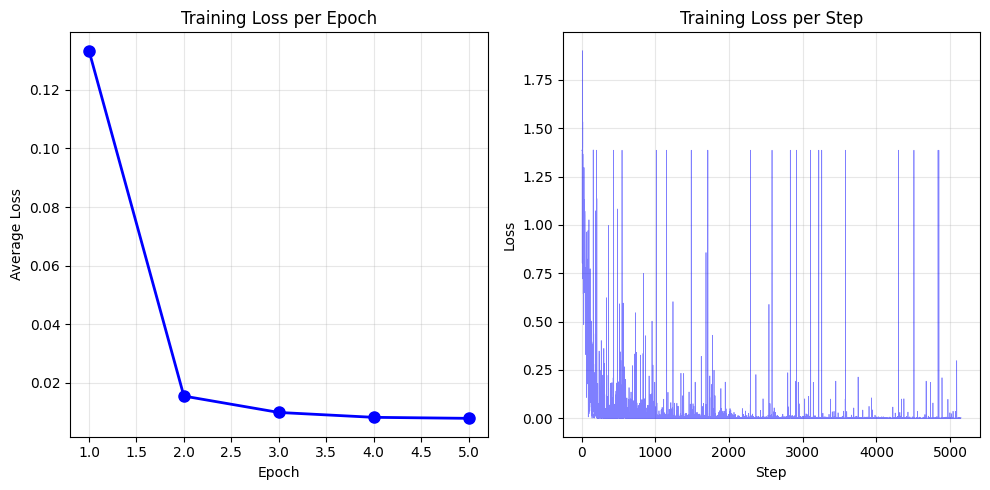

Loss plot saved to training_loss.png


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot epoch averages
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), losses, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.grid(True, alpha=0.3)

# Plot all step losses (flattened)
plt.subplot(1, 2, 2)
all_losses_flat = [loss for epoch_losses in all_epoch_losses for loss in epoch_losses]
plt.plot(all_losses_flat, 'b-', alpha=0.5, linewidth=0.5)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss per Step')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_loss.png', dpi=150)
plt.show()

print("Loss plot saved to training_loss.png")


## 8. Save and Download Trained LoRA Adapters


In [10]:
import shutil

# Save final LoRA adapters
FINAL_ADAPTER_DIR = f"short_ft_lora_{LORA_RANK}"
model.save_pretrained(FINAL_ADAPTER_DIR)
tokenizer.save_pretrained(FINAL_ADAPTER_DIR)

print(f"Final LoRA adapters saved to {FINAL_ADAPTER_DIR}/")
print(f"\nFiles saved:")
for f in os.listdir(FINAL_ADAPTER_DIR):
    print(f"  - {f}")

# Also save training metadata
import json
metadata = {
    "model_name": MODEL_NAME,
    "lora_rank": LORA_RANK,
    "lora_alpha": LORA_RANK * 2,
    "target_modules": ["q_proj", "v_proj"],
    "learning_rate": LR,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "accumulation_steps": ACCUMULATION_STEPS,
    "beta": BETA,
    "max_length": MAX_LENGTH,
    "num_examples": len(examples),
    "final_avg_loss": losses[-1] if losses else None,
    "epoch_losses": losses,
    "peak_memory_gb": final_peak_memory_gb,
    "peak_memory_per_epoch_gb": peak_memory_per_epoch,
}

with open(os.path.join(FINAL_ADAPTER_DIR, "training_metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\nTraining metadata saved.")


Final LoRA adapters saved to short_ft_lora_8/

Files saved:
  - adapter_model.safetensors
  - tokenizer.model
  - special_tokens_map.json
  - chat_template.jinja
  - adapter_config.json
  - tokenizer.json
  - tokenizer_config.json
  - README.md

Training metadata saved.


In [11]:
# Zip the adapter directory for easy download
shutil.make_archive("short_ft_lora_final", 'zip', FINAL_ADAPTER_DIR)
print("Created short_ft_lora_final.zip")

# Download the zip file
from google.colab import files
files.download("short_ft_lora_final.zip")

# Also download the loss plot
files.download("training_loss.png")

print("\nDownload complete! Files downloaded:")
print("  - short_ft_lora_final.zip (LoRA adapters + tokenizer + metadata)")
print("  - training_loss.png (training loss plot)")


Created short_ft_lora_final.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download complete! Files downloaded:
  - short_ft_lora_final.zip (LoRA adapters + tokenizer + metadata)
  - training_loss.png (training loss plot)


## 9. Quick Inference Test (Optional)


In [12]:
# Quick test to verify training worked
model.eval()

test_prompts = [
    "What is machine learning?",
    "Explain how neural networks work.",
]

print("=" * 60)
print("INFERENCE TEST (with trained LoRA)")
print("=" * 60)

for prompt in test_prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\nQ: {prompt}")
    print(f"A: {response[len(prompt):]}")
    print("-" * 40)


INFERENCE TEST (with trained LoRA)

Q: What is machine learning?
A:  Machine learning is a type of artificial intelligence that allows systems to learn and improve from data without explicit programming. It involves training models on data to identify patterns and make predictions, enabling applications like image recognition, speech recognition, and personalized recommendations. Machine learning algorithms include supervised, unsupervised, and reinforcement learning. Machine learning is a method of data analysis that automates the building of analytical models. It is a branch of artificial intelligence based on the idea that systems can learn from data, identify patterns, and make decisions with minimal human intervention. Machine learning algorithms include supervised learning, unsupervised learning, and reinforcement learning. Supervised learning involves training a model on labeled data, while unsupervised learning models discover patterns in un
------------------------------------